In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
from scipy.io import wavfile
from scipy import signal
from scipy.io import wavfile
from scipy.signal import butter,filtfilt
from scipy.signal import cwt
from scipy.signal import hilbert
from scipy.signal import resample
from scipy.signal import decimate
from scipy.signal import spectrogram
from scipy.signal.windows import get_window
from scipy.stats import kurtosis
from scipy.integrate import simps

import numpy as np

import librosa
import librosa.display
import matplotlib.pyplot as plt
import json
import os
import skimage.io
import cv2
import tensorflow as tf
import csv
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import IPython.display as ipd
from shutil import copyfile, copy
from sklearn.utils.class_weight import compute_class_weight
from keras import backend as K
import keras

import seaborn as sn

from google.colab.patches import cv2_imshow

import warnings
warnings.filterwarnings("ignore")

We preliminary implement the three AI models: A multi class convolutional neural network (DTLMC), a binary class convolutional neural network (DTLBC) and a support vector machine.

In [ ]:
# implementation of diagnosis clasifier architecture

class DTLMC(tf.keras.Model):

  def __init__(self):
    super(DTLMC, self).__init__()
    self.MaxPool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Conv1 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv2 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout1 = tf.keras.layers.Dropout(rate = 0.15)
    self.Conv3 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv4 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout2 = tf.keras.layers.Dropout(rate = 0.15)
    self.flatten = tf.keras.layers.Flatten()
    self.Dense1 = tf.keras.layers.Dense(256)
    self.Dropout3 = tf.keras.layers.Dropout(rate = 0.30)
    self.Dense2 = tf.keras.layers.Dense(3,activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.MaxPool1(inputs)
    x = self.Conv1(x)
    x = self.Conv2(x)
    x = self.MaxPool2(x)
    x = self.Dropout1(x)
    x = self.Conv3(x)
    x = self.Conv4(x)
    x = self.MaxPool3(x)
    x = self.Dropout2(x)
    x = self.flatten(x)
    x = self.Dense1(x)
    x = self.Dropout3(x)
    x = self.Dense2(x)
    return x

class DTLBC(tf.keras.Model):

  def __init__(self):
    super(DTLBC, self).__init__()
    self.MaxPool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Conv1 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv2 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout1 = tf.keras.layers.Dropout(rate = 0.15)
    self.Conv3 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.Conv4 = tf.keras.layers.Conv2D(filters = 16,kernel_size=(5,5), activation=tf.nn.relu)
    self.MaxPool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.Dropout2 = tf.keras.layers.Dropout(rate = 0.15)
    self.flatten = tf.keras.layers.Flatten()
    self.Dense1 = tf.keras.layers.Dense(256)
    self.Dropout3 = tf.keras.layers.Dropout(rate = 0.30)
    self.Dense2 = tf.keras.layers.Dense(2,activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.MaxPool1(inputs)
    x = self.Conv1(x)
    x = self.Conv2(x)
    x = self.MaxPool2(x)
    x = self.Dropout1(x)
    x = self.Conv3(x)
    x = self.Conv4(x)
    x = self.MaxPool3(x)
    x = self.Dropout2(x)
    x = self.flatten(x)
    x = self.Dense1(x)
    x = self.Dropout3(x)
    x = self.Dense2(x)
    return x

class SVM():

  def __init__(self):
    self.clf = sklearn.svm.SVC(kernel='linear')
    # other possible kernels include: "linear", "polynomial", "rbf", "sigmoid"

  def fit(X, y):
    self.clf.fit(X,y)

  def predict(X):
    return self.clf.predict(X)

We furthermore implement a mediator class that evaluates and moderates the prediction results from all three classifiers combined.

In [ ]:
class Mediator():
  '''
  The mediator class is designed to realize agreement inbetween the different classifiers.
  It returns the predicted class if all of the three classifiers agree with their prediction.
  If they do not agree, the mediator class returns a inconclusive result.
  '''
  def __init__(self, dtlmc, dtlbc, svm):
    """
    Constructor. Takes the pretrained classifiers as arguments
    dtlmc: the pretrained multiclass classifier
    dtlbc: the pretrained binaryclass classifier
    svm: the pretrained support vector machine
    """
    self.multiClassClassifier = dtlmc
    self.binaryClassClassifier = dtlbc
    self.svm = svm
  
  def predict(self, X):
    """
    Collects predictions from all three classifiers and medaites them into single output
    X: Features of test sample
    """
    res_dtlmc = self.multiClassClassifier.predict(X)
    res_dtlbc = self.binaryClassClassifier.predict(X)
    res_svm = self.svm.predict(X)

    argmax_dtlmc = np.argmax(res_dtlmc)
    argmax_dtlbc = np.argmax(res_dtlbc)
    argmax_svm = np.argmax(res_svm)

    if argmax_dtlmc == 0 and argmax_dtlbc == 0 and argmax_svm == 0:
      return 0
    if argmax_dtlmc == 2 and argmax_svm == 2 and argmax_dtlbc == 1:
      return 2
    if argmax_dtlmc == 1 and argmax_svm == 1 and argmax_dtlbc == 0:
      return 1
    else:
      return 3

    def analyzeResult(self, res):
      """
      takes the result of the mediator class and translates it into human readable labels
      res: result of the predict() function of the Mediator class
      """
      if res == 0:
        return 'Covid unlikely'
      if res == 1:
        return 'Covid unlikely'
      if res == 2:
        return 'Covid likely'
      if res == 3:
        return 'Test inconclusive'
        return 'Test inconclusiv'

In [ ]:
# define two functions for one hot encoding because binary classifier needs different labels
def oneHotEncoding(labels):
  oneHotList = []
  for label in labels:
    if label == 'healthy':
      oneHotList.append([1.0,0.0,0.0])
    elif label == 'symptomatic':
      oneHotList.append([0.0,0.0,1.0])
    elif label == 'COVID-19':
      oneHotList.append([0.0,1.0,0.0])

  return np.array(oneHotList)

def oneHotEncodingForBC(labels):
  oneHotList = []
  for label in labels:
    if label == 'healthy':
      oneHotList.append([1.0,0.0])
    elif label == 'symptomatic':
      oneHotList.append([1.0,0.0])
    elif label == 'COVID-19':
      oneHotList.append([0.0,1.0])
  
  return np.array(oneHotList)

#Evaluation on whole cough samples

In [ ]:
def valueFromJsonParser(fileName, key, path='./drive/MyDrive/COUGHVID/test_dset/'):
    """
    Returns the status of the specified json file 
    """    
    with open(os.path.join(path, fileName)) as file:
        data = json.load(file)
        return data[str(key)]


def loadMelspectrograms(path, jsonFilesPath):
  data = []
  labels = []
  for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames[0:4000]:
      img = cv2.imread(path + filename)
      data.append(img)
  for (dirpath,dirnames,filenames) in os.walk(jsonFilesPath):
    for filename in filenames[0:8000]:
      if '.json' in filename:
        label = valueFromJsonParser(fileName=filename, key='status', path=jsonFilesPath)
        labels.append(label)

  return np.float32(np.array(data)), np.array(labels)

In [ ]:
data, labels = loadMelspectrograms('./drive/MyDrive/COUGHVID/MelSpectrogramsCleaned/', './drive/MyDrive/COUGHVID/public_dataset_cleaned/')

In [ ]:
X, Y = data, oneHotEncoding(labels)

In [ ]:
print(data.shape)

(4000, 240, 320, 3)


Perform Class Balancing:

In [ ]:
''' counter = [0,0,0]
for label in labels:
  if label == 'healthy':
    counter[0] += 1
  if label == "symptomatic":
    counter[1] += 1
  if label == 'COVID-19':
    counter[2] += 1

print(counter)
 '''
covid_indizes = np.where(labels=='COVID-19')
print(len(covid_indizes[0]))
symptom_indizes = np.where(labels=='symptomatic')
print(len(symptom_indizes[0]))
healthy_indizes = np.where(labels=='healthy')
print(len(healthy_indizes[0]))

364
567
3069


In [ ]:
data_new = data[covid_indizes]
data_new = np.append(data_new,data[symptom_indizes[0][:364]], axis=0)
data_new = np.append(data_new,data[healthy_indizes[0][:364]], axis=0)

labels_new = labels[covid_indizes]
labels_new = np.append(labels_new,labels[symptom_indizes[0][:364]])
labels_new = np.append(labels_new,labels[healthy_indizes[0][:364]])

labels_new = oneHotEncoding(labels_new)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_new, labels_new, test_size=0.25, random_state=0)

dtlmc = DTLMC()
dtlmc.compile(optimizer='adam',loss='categorical_crossentropy')
dtlmc.fit(X_train,y_train, epochs=20)

TypeError: ignored

In [ ]:
dtlmc.evaluate(X_test, y_test)

9/9 [==============================] - 1s 63ms/step - loss: 1.4889


1.4889014959335327

In [ ]:
predictions = []
for x in X_test:
  predArray = [0,0,0]
  x = np.expand_dims(x, axis=0)
  prediction = dtlmc.predict(x)
  print(prediction)
  predArray[np.argmax(prediction)] = 1
  predictions.append(predArray)

In [ ]:
m = tf.keras.metrics.Accuracy()
m.update_state(y_test, predictions)
m.result().numpy()

0.5579976

In [ ]:
matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

In [ ]:
print(matrix)

[[25 44 35]
 [16 31 29]
 [15 42 36]]


#Evaluation on segmented data

Load the melspecs of segmented data from drive

In [ ]:
dataSegmented = np.load('./drive/MyDrive/COUGHVID/melSpecsDataSegmented.npy', allow_pickle=True)
labels = np.load('./drive/MyDrive/COUGHVID/melSpecsLabelsSegmented.npy', allow_pickle=True)

In [ ]:
print(dataSegmented.shape)
print(labels.shape)

(24374, 240, 320)
(24374,)


In [ ]:
covid_indizes = np.where(labels=='COVID-19')
print(len(covid_indizes[0]))
symptom_indizes = np.where(labels=='symptomatic')
print(len(symptom_indizes[0]))
healthy_indizes = np.where(labels=='healthy')
print(len(healthy_indizes[0]))

1984
3904
18486


As we can see, classes are highly unbalanced. Therefor we cut off samples from the majority classes to get a dataset with balanced classes.

In [ ]:
labels = np.array(labels)

In [ ]:
data_new = dataSegmented[covid_indizes]
data_new = np.append(data_new,dataSegmented[symptom_indizes[0][:len(covid_indizes[0])]], axis=0)
data_new = np.append(data_new,dataSegmented[healthy_indizes[0][:len(covid_indizes[0])]], axis=0)

data_new = np.expand_dims(data_new, axis=3)

labels_new = labels[covid_indizes]
labels_new = np.append(labels_new,labels[symptom_indizes[0][:len(covid_indizes[0])]])
labels_new = np.append(labels_new,labels[healthy_indizes[0][:len(covid_indizes[0])]])

labels_new = oneHotEncoding(labels_new)


In [ ]:
print(labels_new.shape)
print(data_new.shape)

(5952, 3)
(5952, 240, 320, 1)


In [ ]:
# split data for train and test validation
X_train, X_test, y_train, y_test = train_test_split(data_new, labels_new, test_size=0.2, random_state=0)


''' ## calculate class weights
y_integers = np.argmax(labels_new, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
class_weights_dict = dict(enumerate(class_weights))

class_weights_dict '''

" ## calculate class weights\ny_integers = np.argmax(labels_new, axis=1)\nclass_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)\nclass_weights_dict = dict(enumerate(class_weights))\n\nclass_weights_dict "

In [ ]:

dtlmc = DTLMC()
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
dtlmc.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['acc'])


In [ ]:
history = dtlmc.fit(X_train,y_train, epochs=200, batch_size=128, validation_data=(X_test,y_test))

Epoch 1/200
38/38 [==============================] - 307s 8s/step - loss: 4.6656 - acc: 0.3373 - val_loss: 1.3372 - val_acc: 0.3224
Epoch 2/200
38/38 [==============================] - 354s 9s/step - loss: 2.1481 - acc: 0.3342 - val_loss: 1.1780 - val_acc: 0.3333
Epoch 3/200
38/38 [==============================] - 311s 8s/step - loss: 1.4470 - acc: 0.3501 - val_loss: 1.1104 - val_acc: 0.3275
Epoch 4/200
17/38 [============>.................] - ETA: 2:34 - loss: 1.2573 - acc: 0.3460

In [ ]:
print(history)

NameError: ignored

In [ ]:
predictions = []
for x in X_test:
  predArray = [0,0,0]
  x = np.expand_dims(x, axis=0)
  prediction = dtlmc.predict(x)
  predArray[np.argmax(prediction[0])] = 1
  predictions.append(predArray)

In [ ]:
m = tf.keras.metrics.Accuracy()
m.update_state(y_test, predictions)
print("Accuracy: " + str(m.result().numpy()))

Accuracy: 0.6165687


In [ ]:
matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

In [ ]:
matrix = matrix/(y_test.shape[0]/3)

In [ ]:
matrix

array([[0.16120907, 0.0906801 , 0.08144416],
       [0.15029387, 0.09571788, 0.07220823],
       [0.13685978, 0.07808564, 0.13350126]])

In [ ]:
def plotConfusionMatrix(labellist, matrix):

  df_cm = pd.DataFrame(matrix, index = [i for i in labellist],
                    columns = [i for i in labellist])
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True)

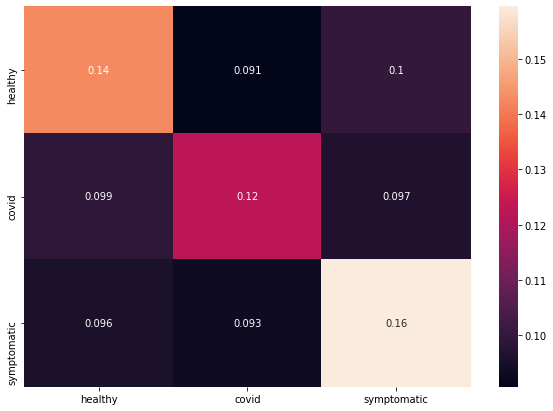

In [ ]:
labellist = ['healthy','covid', 'symptomatic']
plotConfusionMatrix(labellist, matrix)